In [1]:
# --------------------------------------------------------
# (사용시 쥬피터 노트북(.ipynb) 최상단 셀에 복붙하세요)
# --------------------------------------------------------

import sys, os
from pathlib import Path

# 현재 Jupyter Notebook이 실행된 디렉터리가 analysis/인 경우,
# Path().resolve()는 analysis/폴더 경로를 가리킵니다.
# 따라서 .parent.parent로 두 단계 올라가면 프로젝트 루트가 됩니다.
# 경로에 따라서 .parent의 개수를 조정하면 됩니다 최종 base root까지 
BASE_DIR = Path().resolve().parent.parent
# 혹은, 명시적으로 CWD(현재 작업 디렉터리)를 얻고 싶으면:
# BASE_DIR = Path(os.getcwd()).parent.parent

# 프로젝트 루트를 PYTHONPATH에 삽입
if str(BASE_DIR) not in sys.path:
    sys.path.insert(0, str(BASE_DIR))

# 이제 아래 임포트가 정상 동작합니다
from scripts.data_loader import load_data

# 테스트: pm10 데이터 불러오기 -> df_pm10 이 정상적으로 불러진다면 root_path의 설정이 완료 되었습니다.
# 만약 error 발생시 setup.py를 한번 실행시켜 주시기 바랍니다.
df_pm10 = load_data("pm10")

# Hypothesis 3 검증 예시: 초미세먼지(PM2.5)가 미세먼지(PM10)보다 건강에 더 큰 영향을 준다.

=== 가설 #3: PM10 vs PM2.5 종합 분석 결과 ===


,disease,pm_type,pearson_r,pearson_p,spearman_rho,spearman_p,ols_beta,ols_p,ols_r2,n_obs
0,asthma,pm10,0.143207,7.105986e-94,0.397578,0.000000e+00,51.038434,7.105986e-94,0.020508,20390
1,asthma,pm25,0.138429,1.966009e-55,0.320775,3.857657e-302,72.626552,1.966009e-55,0.019162,12715
2,rhinitis,pm10,0.075858,2.059937e-27,0.301130,0.000000e+00,182.078710,2.059937e-27,0.005754,20390
3,rhinitis,pm25,0.109996,1.589031e-35,0.291338,3.358661e-247,518.476036,1.589031e-35,0.012099,12715


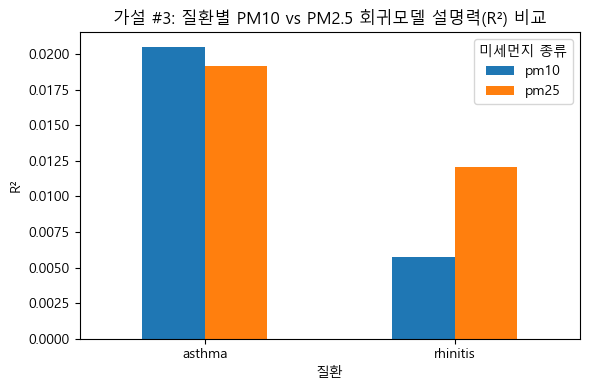

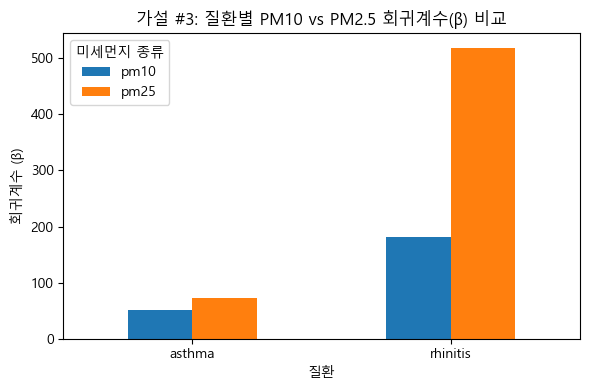

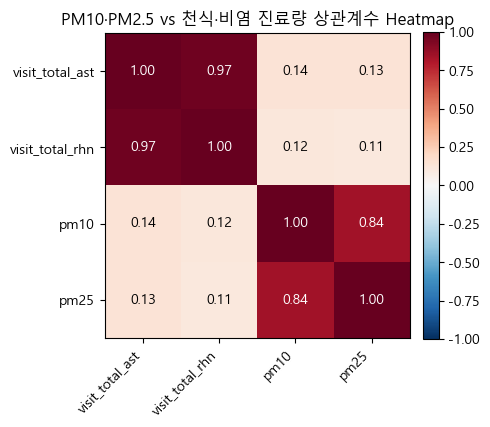

In [ ]:
import pandas as pd
import statsmodels.api as sm
from scipy.stats import pearsonr, spearmanr
from src.utils.db_util import DustDB
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams['font.family'] = 'Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

# ───────────────────────────────────────────────────────────────
# DB 연결 및 Fact 테이블 로드 (ym → date_id로 rename)
# ───────────────────────────────────────────────────────────────
db = DustDB()

# 천식·비염 Fact 테이블: PM10 / PM2.5
#     - 원본 컬럼: id, ym, region_name, age_group, visit_count
#     - 여기서는 age_group을 무시하므로, 컬럼만 남긴 뒤 ym→date_id, region_name→region으로 바꿉니다.
df_pa10 = (
    db.load_table("pm10_asthma_fact")
      .rename(columns={"region_name": "region", "ym": "date_id"})
      # age_group 컬럼이 있어도 집계 단계에서 무시하므로 남겨둡니다.
)
df_pa25 = (
    db.load_table("pm25_asthma_fact")
      .rename(columns={"region_name": "region", "ym": "date_id"})
)
df_pr10 = (
    db.load_table("pm10_rhinitis_fact")
      .rename(columns={"region_name": "region", "ym": "date_id"})
)
df_pr25 = (
    db.load_table("pm25_rhinitis_fact")
      .rename(columns={"region_name": "region", "ym": "date_id"})
)

# PM10/PM2.5 Fact 테이블: 월·지역별 PM 농도
#     - 컬럼: date_id, region_name, pm10 또는 pm25
df_pm10 = (
    db.load_table("pm10_fact")
      .rename(columns={"region_name": "region"})[["date_id", "region", "pm10"]]
      .drop_duplicates()
)
df_pm25 = (
    db.load_table("pm25_fact")
      .rename(columns={"region_name": "region"})[["date_id", "region", "pm25"]]
      .drop_duplicates()
)

# ───────────────────────────────────────────────────────────────
# “월·지역별 총 진료량” 집계 함수 (연령대 무시)
# ───────────────────────────────────────────────────────────────
def aggregate_total_visits(df_disease_fact: pd.DataFrame) -> pd.DataFrame:
    """
    df_disease_fact: pm*_asthma_fact 또는 pm*_rhinitis_fact DataFrame
        (컬럼: id, date_id, region, age_group, visit_count)
    반환: date_id, region별 연령대 무시한 총 visit_count (visit_total)
    """
    agg = (
        df_disease_fact
        .groupby(["date_id", "region"], as_index=False)[["visit_count"]]
        .sum()
        .rename(columns={"visit_count": "visit_total"})
    )
    return agg

# 천식 전체(연령 무시)
df_asthma10 = aggregate_total_visits(df_pa10)   # (date_id, region, visit_total)
df_asthma25 = aggregate_total_visits(df_pa25)

# 비염 전체(연령 무시)
df_rhinitis10 = aggregate_total_visits(df_pr10)
df_rhinitis25 = aggregate_total_visits(df_pr25)

# ───────────────────────────────────────────────────────────────
# 상관·회귀 분석 함수 정의 (연령 무시, 전체 sensitivity)
# ───────────────────────────────────────────────────────────────
def analyze_overall_sensitivity(df_visits: pd.DataFrame,
                                df_pm: pd.DataFrame,
                                pm_col: str,
                                label_disease: str,
                                label_pm: str) -> pd.DataFrame:
    """
    df_visits    : 월·지역별 총 진료량 DataFrame (date_id, region, visit_total)
    df_pm        : 월·지역별 PM 농도 DataFrame (date_id, region, pm_col)
    pm_col       : 'pm10' 또는 'pm25'
    label_disease: 'asthma' 또는 'rhinitis' (결과 레이블용)
    label_pm     : 'pm10' 또는 'pm25'
    
    반환: 단일 row DataFrame = 하나의 질환-미세먼지 유형 분석 결과
        컬럼: disease, pm_type,
              pearson_r, pearson_p,
              spearman_rho, spearman_p,
              ols_beta, ols_p, ols_r2,
              n_obs (분석에 사용된 표본 개수)
    """
    # 월·지역 기준으로 merge → visit_total vs pm_col
    df_merge = pd.merge(
        df_visits,
        df_pm,
        on=["date_id", "region"],
        how="inner"
    ).dropna(subset=[pm_col, "visit_total"])
    
    # 표본 개수
    n_obs = len(df_merge)
    if n_obs < 5:
        # 표본이 너무 적으면 불안정 → 빈 DataFrame 반환
        return pd.DataFrame()
    
    #  Pearson / Spearman 계산
    pear_r, pear_p = pearsonr(df_merge[pm_col], df_merge["visit_total"])
    rho, sp_p = spearmanr(df_merge[pm_col], df_merge["visit_total"])
    
    # OLS 회귀 (y = visit_total, X = pm_col)
    X = sm.add_constant(df_merge[[pm_col]])  # 상수항 추가
    y = df_merge["visit_total"]
    model = sm.OLS(y, X).fit()
    beta = model.params[pm_col]
    pval = model.pvalues[pm_col]
    r2 = model.rsquared
    
    # 결과 정리
    result = {
        "disease":      label_disease,
        "pm_type":      label_pm,
        "pearson_r":    pear_r,
        "pearson_p":    pear_p,
        "spearman_rho": rho,
        "spearman_p":   sp_p,
        "ols_beta":     beta,
        "ols_p":        pval,
        "ols_r2":       r2,
        "n_obs":        n_obs
    }
    return pd.DataFrame([result])


# ───────────────────────────────────────────────────────────────
# 천식·비염 각각에 대해 PM10 vs PM2.5 분석 실행
# ───────────────────────────────────────────────────────────────

# --- 천식 vs PM10 ---
df_res_asthma_pm10 = analyze_overall_sensitivity(
    df_asthma10, df_pm10, "pm10", label_disease="asthma", label_pm="pm10"
)

# --- 천식 vs PM2.5 ---
df_res_asthma_pm25 = analyze_overall_sensitivity(
    df_asthma25, df_pm25, "pm25", label_disease="asthma", label_pm="pm25"
)

# --- 비염 vs PM10 ---
df_res_rhinitis_pm10 = analyze_overall_sensitivity(
    df_rhinitis10, df_pm10, "pm10", label_disease="rhinitis", label_pm="pm10"
)

# --- 비염 vs PM2.5 ---
df_res_rhinitis_pm25 = analyze_overall_sensitivity(
    df_rhinitis25, df_pm25, "pm25", label_disease="rhinitis", label_pm="pm25"
)

# (결과 합치기)
df_out = pd.concat([
    df_res_asthma_pm10,
    df_res_asthma_pm25,
    df_res_rhinitis_pm10,
    df_res_rhinitis_pm25
], ignore_index=True)

print("=== 가설 #3: PM10 vs PM2.5 종합 분석 결과 ===")
display(df_out)


# ───────────────────────────────────────────────────────────────
# R² 및 회귀계수 시각화 예시 (막대그래프)
# ───────────────────────────────────────────────────────────────
if not df_out.empty:
    # 질환별 PM10 vs PM2.5 모델 설명력(R²) 비교
    df_r2_plot = df_out.pivot(index="disease", columns="pm_type", values="ols_r2")
    ax1 = df_r2_plot.plot.bar(
        figsize=(6, 4),
        title="가설 #3: 질환별 PM10 vs PM2.5 회귀모델 설명력(R²) 비교",
        ylabel="R²",
        xlabel="질환",
        rot=0
    )
    ax1.legend(title="미세먼지 종류")
    plt.tight_layout()
    plt.show()

    # 질환별 PM10 vs PM2.5 모델 회귀계수(β) 비교
    df_beta_plot = df_out.pivot(index="disease", columns="pm_type", values="ols_beta")
    ax2 = df_beta_plot.plot.bar(
        figsize=(6, 4),
        title="가설 #3: 질환별 PM10 vs PM2.5 회귀계수(β) 비교",
        ylabel="회귀계수 (β)",
        xlabel="질환",
        rot=0
    )
    ax2.legend(title="미세먼지 종류")
    plt.tight_layout()
    plt.show()


# ───────────────────────────────────────────────────────────────
# 전체 데이터 상관계수 Heatmap
# ───────────────────────────────────────────────────────────────

# 월·지역별 천식·비염 진료량과 PM 데이터를 모두 머지
df_merged_all = pd.merge(df_asthma10, df_rhinitis10, on=["date_id", "region"], how="outer", suffixes=("_ast", "_rhn"))
df_merged_all = pd.merge(df_merged_all, df_pm10, on=["date_id", "region"], how="outer")
df_merged_all = pd.merge(df_merged_all, df_pm25, on=["date_id", "region"], how="outer")

# 컬럼명 정리: visit_total_ast, visit_total_rhn, pm10, pm25
df_corr = df_merged_all[["visit_total_ast", "visit_total_rhn", "pm10", "pm25"]].dropna()
corr_matrix = df_corr.corr(method="pearson")

# 상관계수 Heatmap 그리기 (matplotlib only)
fig, ax = plt.subplots(figsize=(5, 5))
im = ax.imshow(corr_matrix, cmap="RdBu_r", vmin=-1, vmax=1)  # -1~1 사이 색상 매핑

# x축/ y축 tick에 라벨 표시
ax.set_xticks(range(len(corr_matrix.columns)))
ax.set_yticks(range(len(corr_matrix.index)))
ax.set_xticklabels(corr_matrix.columns, rotation=45, ha="right")
ax.set_yticklabels(corr_matrix.index)

# 각 셀 안에 숫자 값 쓰기
for i in range(len(corr_matrix.index)):
    for j in range(len(corr_matrix.columns)):
        text = f"{corr_matrix.iloc[i, j]:.2f}"
        ax.text(j, i, text, ha="center", va="center",
                color="white" if abs(corr_matrix.iloc[i, j]) > 0.5 else "black")

ax.set_title("PM10·PM2.5 vs 천식·비염 진료량 상관계수 Heatmap")
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

# 종합 결론
### 회귀계수(β) 관점

천식·비염 모두 PM2.5 단위 증가 시 진료량 증가폭이 PM10보다 크며, 특히 비염에서는 β가 PM10의 약 2.8배나 됩니다.

→ “초미세먼지(PM2.5)가 미세먼지(PM10)보다 개별 환자 수 증가 효과가 더 크다”는 가설을 명확히 지지.

### 설명력(R²) 관점

천식: PM10 R²≈2.05% vs PM2.5 R²≈1.92% → 거의 비슷

비염: PM10 R²≈0.58% vs PM2.5 R²≈1.21% → PM2.5 쪽 압도적 우세

→ “비염 진료량 변동은 특히 PM2.5가 PM10보다 더 잘 설명한다. 천식은 두 미세먼지 모두 설명력이 매우 낮고 큰 차이 없음.”

### 상관계수 구조

천식·비염 진료량 간 상관이 0.97로 매우 높음.

PM10·PM2.5 상관이 0.84로 높음.

진료량 vs 미세먼지는 모두 약 0.10~0.14 수준의 ‘아주 약한 상관’만 존재.

→  “진료량 간에는 강한 공통 패턴(예: 계절성, 기타 환경 요인)이 있지만, 미세먼지 하나만으로는 진료량 변동을 거의 설명할 수 없다.”


#### 위 결과를 종합하면, **가설 3 (“초미세먼지(PM2.5)가 미세먼지(PM10)보다 건강(천식·비염)에 더 큰 영향을 준다”)는 β(회귀계수) 지표를 통해 확실히 지지되지만,
모델 설명력(R²) 수치만으로는 여전히 미미한 부분(≈1~2%)만 차지